# Optimization Project: Two Algorithms to solve anomaly detection with Minimum Enclosing Ball

Authors: José Chacón, Inês Jesus , Alejandra Cruces and Mario Tapia

In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.linalg
import time
import gdown
from sklearn.model_selection import train_test_split
from numpy import linalg
from sklearn.metrics.pairwise import euclidean_distances
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Circle
from sklearn.decomposition import PCA
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Set hyperparameters
tol = 1E-4
iter = 100000
step_type_selection = "shortstep" #Options are diminishing and shortstep

# Functions to support the algorithm
- keep_normal_class: For the training part we keep only the normal class of the set
- anomaly_detection: With the radius and the center given by the algorithms, it detects the anomaly points in a new dataset
- metric_anomaly: Calculate the important metrics for the anomaly detection algorithm

In [ ]:
# From the test only keep the "Normal" class to train the model
#Define normal class with a numerical value
def keep_normal_class(X,y, normal_value):
  y_idx = np.where(y == normal_value)
  X_normal = X[y_idx,:][0]
  y_normal = y[y_idx]
  return X_normal, y_normal

In [ ]:
# Function to detect anomaly with a radius and a center
def anomaly_detection(X, r, c):
  dif = (X - c)
  y = np.linalg.norm(dif, axis = 1)-r
  y_anomaly = [0 if i<=1E-6 else 1 for i in y]
  return y_anomaly

In [ ]:
# Precision measures the fraction of detected anomalies that are actually true anomalies,
# while recall measures the fraction of true anomalies that are detected by the model.
def metric_anomaly(y_test, y_predict):

  TP = 0   # True positives
  TN = 0   # True negatives
  FP = 0   # False positive
  FN = 0   # False negatives

  for j in range(0, len(y_predict)):
    if y_test[j] == 1 and y_predict[j] == 1:
      TP += 1
    elif y_test[j] == 1 and y_predict[j] == 0:
      FN += 1
    elif y_test[j] == 0 and y_predict[j] == 0:
      TN += 1
    elif y_test[j] == 0 and y_predict[j] == 1:
      FP += 1

  recall = TP / (TP + FN)
  precision = TP / (TP + FP)
  accuracy =  (TP + TN) / (TP + FN + TN + FP)
  f1_score = (2*precision*recall)/(precision+recall)

  return recall, precision, accuracy, f1_score

In [ ]:
def hessian(X_sqr):
  h = 2*X_sqr
  return h

def lipschitz_constant(hessian_matrix):
    condition_number = np.linalg.eigvalsh(hessian_matrix)[-1]
    check_pos_def = np.linalg.eigvalsh(hessian_matrix)[0]
    print("min eigenvalue:",check_pos_def )
    print("Checking if the matrix is positive definite")
    if check_pos_def> 0:
      print("The matrix is positive definite")
    else:
      print("The matrix is not positive definite")
    return condition_number

In [ ]:
def plot_y_against_two_variables(y1,y2,y3, x1_1, x1_2, x1_3, x2_1, x2_2, x2_3,
                                 legend, x1label, x2label, ylabel, sharey=False, geneDataset = False):
  fig, [[ax1,ax2], [ax3,ax4], [ax5,ax6]] = plt.subplots(nrows=3, ncols=2, sharey=sharey)

  if geneDataset:
    myLocator = mticker.MultipleLocator(25000)
    ax1.xaxis.set_major_locator(myLocator)
    ax3.xaxis.set_major_locator(myLocator)

    myLocator2 = mticker.MultipleLocator(100000)

    ax2.xaxis.set_major_locator(myLocator2)
    ax4.xaxis.set_major_locator(myLocator2)


  l1 = ax1.plot(x1_1, y1, color="b")
  l3 = ax3.plot(x1_2, y2, color="orange")
  l5 = ax5.plot(x1_3, y3, color="g")

  ax1.set(xlabel=x1label)
  ax1.xaxis.set_label_position('top')

  ax1.axvline(x1_1[-1], color="grey", ls="dotted")
  ax3.axvline(x1_2[-1], color="grey", ls="dotted")

  ax5.axvline(x1_3[-1], color="grey", ls="dotted")
  ax3.set(ylabel=ylabel)

  # x_2
  ax2.set(xlabel=x2label)
  ax2.xaxis.set_label_position('top')

  l2 = ax2.plot(x2_1, y1, color="b")
  l4 = ax4.plot(x2_2, y2, color="orange")
  l6 = ax6.plot(x2_3, y3, color="g")

  ax2.axvline(x2_1[-1], color="grey", ls="dotted")
  ax4.axvline(x2_2[-1], color="grey", ls="dotted")
  ax6.axvline(x2_3[-1], color="grey", ls="dotted")

  ax2.set(xlabel=x2label)
  fig.tight_layout()

  legend_elements = [Line2D([0], [0], color='b', lw=2, label=legend[0]),
                   Line2D([0], [0], color='orange',
                          markerfacecolor='g', lw=2, label=legend[1]),
                   Line2D([0], [0],color='g',lw=2, label=legend[2] )]



  fig.legend(handles=legend_elements, loc='lower center' , bbox_to_anchor=(0.51, -0.1) , ncol=len(legend), bbox_transform=fig.transFigure)
  plt.show()


In [ ]:
# Hyperparameter Tuning

def findBestK(X_train, y_train):

    recall_train_bcpg = []
    recall_t = 0
    k_best = 0

    for i in range(2, X_train.shape[1] + 1):

      # Parameter selection
      print("k =", i)
      selection = SelectKBest(k=i).fit(X_train,y_train)
      X_train_kbest = selection.transform(X_train)
      X_normal_kbest, y_normal_kbest = keep_normal_class(X_train_kbest, y_train, normal_value = 0)

      mu_bpcg , center_MEB_bpcg, r_MEB_bpcg, gap_bpcg, iter_count_bpcg, drop_count_bpcg, time_bpcg, radius_bpcg, center_bpcg, size_act_set = BPCG(X_normal_kbest, step_type = step_type_selection)

      # Metrics in the training set
      y_predict_bpcg = anomaly_detection(X_train_kbest, r_MEB_bpcg, center_MEB_bpcg)
      recall_bpcg, precision_bpcg, accuracy_bpcg, f1_score_bpcg = metric_anomaly(y_train, y_predict_bpcg)

      recall_train_bcpg.append(recall_bpcg)

      if recall_bpcg >= recall_t:
        recall_t = recall_bpcg
        k_best = i

    print("best number of parameters = ", k_best)

    return k_best, recall_train_bcpg


In [ ]:
def plt_sphere(c, r, X_test, y_test,ax):
    X_test_anormal, y_test_anormal = keep_normal_class(X_test, y_test, normal_value = 1)
    X_test_normal, y_test_normal = keep_normal_class(X_test, y_test, normal_value = 0)

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = r*np.cos(u)*np.sin(v)
    y = r*np.sin(u)*np.sin(v)
    z = r*np.cos(v)
    ax.plot_wireframe(x + c[0] , y + c[1], z + c[2], color='b',rstride=1, cstride=1, alpha=0.3)
    ax.scatter(X_test_normal[:,0], X_test_normal[:,1], X_test_normal[:,2], color="blue" )
    ax.scatter(X_test_anormal[:,0], X_test_anormal[:,1], X_test_anormal[:,2], color="grey" )

    ax.scatter(c[0], c[1], c[2], color='red')

# Three implementations for the Minimum Enclosing Ball Problem



## Algorithm 1: Pairwise Frank Wolfe

This algorithm follows almost the same procedure of the Away-Steps Frank-Wolfe [Wolfe (1970)], where there is the possibility to move away from an active atom,  except that now the direction chosen in every step is based on a weight change from the away atom $v_t$ to the FW atom $s_t$.

In [ ]:
# PFW algorithm

# X dataset as rows instances and columns features,
# So, X transpose's rows are dimensions or features and columns are instances

def PFW(X, it=iter, tol = tol, step_type = "diminishing"):

  print("Using ", step_type, " as step size type")

  #Keep iteration number
  iter_count = 0

  # To keep track of the gap,  drop step and size active set
  trace_gap = []
  drop_count = 0
  size_act_set = []

  # Transpose matrix
  X_mat = X.T

  # Calculate the matrix multiplication between X_normal transpose and X_normal
  X_sqr = np.dot(X_mat.T, X_mat)

  # Calculate the z
  vecD = np.diag(X_sqr)

  #The shape of the matrix
  n = X.shape[0]

  #The identity matrix
  mat_id = np.identity(n)

  # Initialization
  mu = np.ones(n) / n
  r_ = []
  c_ = []

  # Active set, Initialization
  S = np.vstack((mat_id, mu))

  # alpha is a vector of weights. S*alpha = Active Set
  alpha = np.zeros((n+1,1))
  alpha[-1] = 1

  #If step size type is short step, calculate Lipschitz constant
  if step_type == "shortstep":
    hessian_mat = hessian(X_sqr)
    L = lipschitz_constant(hessian_mat)
    print("Lipschitz:", L)

  #Keep time track
  time_ = []
  time0 = time.time() * 1000

  for t in range(it):

    #Update iteration
    iter_count += 1

    #Gradient
    grad = 2. * np.dot(X_sqr, mu) - vecD
    a_set = S[np.where(alpha > 0)[0]]

    #Argmax of away vertex
    at_idx = np.argmax(np.dot(a_set, grad))
    at = a_set[at_idx]

    #Argmin global FW
    wt_idx = np.argmin(grad)
    wt = mat_id[wt_idx]

    # Pairwise and FW directions calculation
    FW_dir = mu-wt

    # Calculation of gap
    FW_gp = np.dot(grad, FW_dir)

    if FW_gp <= tol:
      print("Early Stopping")
      print("Iteration number: ", t, "of ", it)

      trace_gap.append(FW_gp)
      r_.append(r_[-1])
      time_.append(time.time()*1000 - time0)
      break

    # Setting the Pairwise Frank Wolfe direction
    PFW_dir = at - wt

    #Choosing Step type
    #Calculate step size if step type = diminishing
    if step_type == "diminishing":
      beta = 2. / (t+2)

    #Line search calculate step size with PFW direction
    if step_type == "shortstep":
      beta = np.dot(grad, PFW_dir) / (L*(np.linalg.norm(PFW_dir)**2))

    #To track the position of at
    if (at == S[-1]).all():
        pos_at = -1
    else:
    #As at is a vector of 0's and 1's where the dimension corresponds to position == 1 and correlates to position in matrix S
        pos_at = np.where(at == 1)[0]

    # Choosing step size
    lambda_t = max(0, min(alpha[pos_at][0], beta))

    #To track position of wt
    if (wt == S[-1]).all():
        pos_wt = -1
    else:
        pos_wt = np.where(wt == 1)[0]

    # Mass moving between Away and FW atom (weights update)
    alpha[pos_at] += -lambda_t
    alpha[pos_wt] += lambda_t

    if alpha[pos_at] < 0:
        alpha[pos_at] = 0

    #Keeping track of the gap
    trace_gap.append(FW_gp)

    #Update solution
    mu += -lambda_t * PFW_dir

    #To Keep track CPU time
    time_.append(time.time()*1000 - time0)

    #Keep track of the size of the active set
    size_act_set.append(a_set.shape[0])

    #Center and radius
    radius_aux = np.sqrt(np.dot(vecD, mu) - np.dot(mu, np.dot(X_sqr, mu)))
    r_.append(radius_aux)

    center_aux = np.dot(X_mat, mu)
    c_.append(np.linalg.norm(center_aux))

  #Calculate the center with the solution
  center_MEB = np.dot(X_mat, mu)

  # Calculate the radius with the solution
  r_MEB = np.sqrt(np.dot(vecD, mu) - np.dot(mu, np.dot(X_sqr, mu)))

  if iter_count == it:
    print("Maximum number of iterations reached")

  return mu, center_MEB, r_MEB, trace_gap, iter_count, time_, r_, c_, size_act_set

## Algorithm 2: Blended Pairwise Conditional Gradient

The second algorithm that we present proposes a modification of the Pairwise FW algorithm (Tsuji 2021). Taking ideas from the Blended Conditional Gradient Algorithm , a blending criterion is added which more precisely favours local steps made over the convex hull of the current active vertex set.


In [ ]:
# BPCG algorithm
# Fixed step size

# X dataset as rows instances and columns features,
# So, X transpose's rows are dimensions or features and columns are instances

def BPCG(X, it=iter, tol = tol, step_type = "diminishing"):

  print("Using ", step_type, " as step size")

  #Keep iteration number
  iter_count = 0 #[0]

  # to keep track of the gap,  drop step and size active set
  trace_gap = []
  drop_count = 0
  size_act_set = []

  # Transpose matrix
  X_mat = X.T

  # Calculate the matrix multiplication between X_normal transpose and X_normal
  X_sqr = np.dot(X_mat.T, X_mat)

  # Calculate the z
  vecD = np.diag(X_sqr)

  # The shape of the matrix
  n = X.shape[0]

  #The identity matrix
  mat_id = np.identity(n)

  # Initialization
  mu = np.ones(n) / n
  r_ = []
  c_ = []

  # Active set, Initialization
  S = np.vstack((mat_id, mu))

  # alpha is a vector of weights. S*alpha = Active Set
  alpha = np.zeros((n+1,1))
  alpha[-1] = 1

  #Calculate Lipschitz constant
  if step_type == "shortstep":
    hessian_mat = hessian(X_sqr)
    L = lipschitz_constant(hessian_mat)
    print("Lipschitz:", L)

  #Keep time track
  time_ = [] #[0]
  time0 = time.time() * 1000

  for t in range(it):

    #Update iteration count
    iter_count += 1

    #Calculate step size if step type = diminishing
    if step_type == "diminishing":
      beta = 2. / (t+2)

    #Gradient
    grad = 2. * np.dot(X_sqr, mu) - vecD
    a_set = S[np.where(alpha > 0)[0]]

    #Argmax of away vertex
    at_idx = np.argmax(np.dot(a_set, grad))
    at = a_set[at_idx]
    #Argmin local FW
    st_idx = np.argmin(np.dot(a_set, grad))
    st = a_set[st_idx]
    #Argmin global FW
    wt_idx = np.argmin(grad)
    wt = mat_id[wt_idx]

    # Pairwise and FW directions calculation
    PW_dir = at-st
    FW_dir = mu-wt

    # Calculation of gaps
    PW_gp = np.dot(grad, PW_dir)
    FW_gp = np.dot(grad, FW_dir)

    if FW_gp <= tol:
      print("Early Stopping")
      print("Iteration number: ", t, "of ", it)
      trace_gap.append(FW_gp)
      r_.append(r_[-1])
      time_.append(time.time()*1000 - time0)
      break

    if PW_gp >= FW_gp + 1E-5:
      #Pairwise step
      #Keeping track of the gap
      trace_gap.append(PW_gp)

      #To track the position of at
      if (at == S[-1]).all():
        pos_at = -1
      else:
        #As at is a vector of 0's and 1's where the dimension corresponds to position == 1 and correlates to position in matrix S
        pos_at = np.where(at == 1)[0]

      #To track the position of st
      if (st == S[-1]).all():
        pos_st = -1
      else:
        pos_st = np.where(st == 1)[0]

      dir_ = PW_dir
      lambda_max = alpha[pos_at][0] #the weight of the atom

      #Calculate step size if step type is linesearch and direction is PW
      if step_type == "shortstep":
        beta = PW_gp / (L*(np.linalg.norm(dir_)**2))

      ##Step size is at most the weight
      lambda_t = max(0, min(beta, lambda_max))

      if lambda_t < lambda_max: #descent step
        # The active set remains the same
        # Updating weights

        alpha[pos_at] += -lambda_t
        alpha[pos_st] += lambda_t

      else: # drop step
        # Remove at from the active set
        # Set the alpha of at to zero
        alpha[pos_at] = 0
        alpha[pos_st] += lambda_t
        drop_count += 1

    else: #FW step
      #Keeping track of the gap
      trace_gap.append(FW_gp)

      #To track position of wt
      if (wt == S[-1]).all():
        pos_wt = -1
      else:
        pos_wt = np.where(wt == 1)[0]

      dir_ = FW_dir

      #Calculate step size if step type is linesearch and direction is FW
      if step_type == "shortstep":
        beta = FW_gp / (L*(np.linalg.norm(dir_)**2))

      #Step size is at most 1
      lambda_t = max(0, min(beta, 1))

      if lambda_t == 1: # The active set is only the new wt
        alpha = np.zeros((n+1, 1))
        alpha[pos_wt] += lambda_t

      else:
        alpha = alpha*(1-lambda_t)
        alpha[pos_wt] += lambda_t

    #Update solution
    mu += -lambda_t * dir_

    #To Keep track CPU time
    time_.append(time.time()*1000 - time0)

    #Keep track of the size of the active set
    size_act_set.append(a_set.shape[0])

    #Center and radius
    radius_aux = np.sqrt(np.dot(vecD, mu) - np.dot(mu, np.dot(X_sqr, mu)))
    r_.append(radius_aux)
    center_aux = np.dot(X_mat, mu)
    c_.append(np.linalg.norm(center_aux))

  #Calculate the center with the solution
  center_MEB = center_aux #c_[-1]

  # Calculate the radiuos with the solution
  r_MEB = radius_aux #r_[-1]

  if iter_count == it:
    print("Maximum number of iterations reached")

  return mu, center_MEB, r_MEB, trace_gap, iter_count, drop_count, time_, r_, c_, size_act_set

## Algorithm 3: MEB (1 + ϵ) approximation algorithm with away steps

**Objective function**

In [ ]:
#Computing the objective function of the dual formulation of the MEB problem
def phi(u, X):
    first_term = np.sum([np.dot(u[ix] * row.T, row) for ix, row in enumerate(X)])
    second_term = np.dot(np.dot(u,X).T , np.dot(u,X))
    phi = first_term - second_term
    return phi

**Setting up initial parameters values*
*   α : Index of farthest point from first element of input set (used in preparation to set initial center and radius)
*   β  : Index of farthest point from α-element of input set (used in preparation to set initial center and radius)
*   κ : Index of farthest point from the current center
*   ξ : Index of closest coreset point from the current center

* u : Array-set that serves to store the weights to be used in  the convex combination of elements of the input set  to determine the center of the trial ball

 Also used as input of the objective function to determine  γ, which is used to obtain the radius

*  $ \delta ^+ $ : Smallest number such that the trial ball encloses the input set if its radius is expanded  by a factor of  $ (1 + \delta) ^{1/2} $

* $ \delta ^- $ : Largest number such that the current ball shrunken by a factor of  $ (1 - \delta) ^{1/2} $ does not contain any points in the current coreset for any $ \delta >  \delta ^- $

In [ ]:
def initial_values(X):
  #Defining alpha and beta
  squared_norm_wrt_first_elem = np.power(np.linalg.norm(X - X[0], axis=1), 2)
  alpha = np.argmax(squared_norm_wrt_first_elem)

  squared_norm_wrt_alpha_elem = np.power(np.linalg.norm(X - X[alpha], axis=1),2)
  beta = np.argmax(squared_norm_wrt_alpha_elem)

  #Initial construction of u array
  u = np.zeros((X.shape[0]))
  u[alpha] = 0.5
  u[beta] = 0.5

  #Initialization of coreset
  coreset = np.array([alpha, beta])

  #Initial center
  center= np.dot(u, X)

  #Initial gamma value
  gamma = phi(u, X)

  #Setting initial values of kappa and xi to obtain the farthest and closest point from the current center
  squared_norm_wrt_center = np.power(np.linalg.norm(X - center, axis=1), 2)
  kappa = np.argmax(squared_norm_wrt_center) # κ
  xi = coreset[np.argmin(squared_norm_wrt_center[coreset])] # ξ

  #Setting initial delta value
  delta_plus = (np.power(np.linalg.norm(X[kappa] - center), 2) / gamma) - 1
  delta_minus = 1 - (np.power(np.linalg.norm(X[xi] - center), 2) / gamma)

  delta = max(delta_plus, delta_minus)

  return coreset, center, kappa, gamma, xi, delta, delta_plus, delta_minus, u

**Improving the trial ball through iterations**

In [ ]:
def algorithm_meb(X, coreset, center, kappa, gamma, xi, delta, delta_plus, delta_minus, u, eps = tol, it = iter):

  #Initial values
  print("Initial values", "\n")
  print("Gamma ", gamma )
  print("Delta " , delta, "\n")

  #Saving initial parameters values
  coreset_history = [coreset]
  center_history = center[:]
  kappa_history =  [kappa]
  gamma_history = [gamma]
  xi_history = [xi]
  radius_history = [gamma** 0.5]

  #Keep track of the gradient
  delta_history = [delta]

  #Keep time track and iterations
  time_ = [0]
  time0 = time.time() * 1000
  iter_count = 0

  for i in range(it):
      #Iteration update

      iter_count += 1

      if delta < ((1 + eps)**2 - 1): #Termination criterion
          print("Early Stopping")
          print("Iteration number: ", i, "of ", it)
          break

      if delta > delta_minus:   #Plus iteration

        _lambda = delta / (2 * (1 + delta))

        u = ((1 - _lambda) * u)
        u[kappa] += _lambda

        #New center is computed by shifting toward the farthest point which is added to the coreset
        center = ((1 - _lambda) * center) + (_lambda *  X[kappa])
        coreset = np.append(coreset, kappa)

        #Saving current iterate parameters values
        kappa_history.append(kappa)
        xi_history.append(None)

      else: #Minus iteration

        #candidates to be the new stepsize
        delta_lambda_cand = delta_minus/(2*(1-delta_minus))
        u_xi_lambda_cand =  u[xi]/(1-u[xi])

        _lambda = min(delta_lambda_cand, u_xi_lambda_cand) #to ensure dual feasability constraint u >= 0

        if _lambda == u_xi_lambda_cand: #In the case u component of the closest coreset point from the center drops to zero
          coreset = np.delete(coreset, np.where(coreset == xi)) # element discarded from the working core set
        #u array-set updated
        u = ((1 + _lambda) * u)
        u[xi] -= _lambda

        #New center is obtained by moving the current center away from the closest point
        center = ((1 + _lambda) * center) - (_lambda *  X[xi])

        #Saving current iterate parameters values
        kappa_history.append(None)
        xi_history.append(xi)

      #Update objective function result for current iteration u array-set
      gamma = phi(u, X)

      #Update values for kappa and xi wrt current iteration center
      squared_norm_wrt_center = np.power(np.linalg.norm(X - center, axis=1), 2)
      kappa = np.argmax(squared_norm_wrt_center)
      xi = coreset[np.argmin(squared_norm_wrt_center[coreset])]

      #Update delta value
      delta_plus = (np.power(np.linalg.norm(X[kappa] - center), 2) / gamma) - 1
      delta_minus = 1 - (np.power(np.linalg.norm(X[xi] - center), 2) / gamma)
      delta = max(delta_plus, delta_minus)
      delta_history.append(delta)

      #Calculate cpu time
      time_.append(time.time()*1000 - time0)

      #Saving current iterate parameters values
      coreset_history.append(coreset)
      center_history = np.vstack([center_history, center])
      gamma_history.append(gamma)
      radius_history.append(gamma** 0.5)

  if iter_count == it:
    print("Maximum number of iterations reached")

  radius = ((1+delta) * gamma) ** 0.5

  return delta_history, radius, coreset_history, center, kappa_history, gamma_history, xi_history, radius_history, time_, iter_count

# Load Data set

## Dataset 1: Breast cancer dataset
- Source: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
- Objective: Detect the tumors that al malign
- Dimension: 569 instances, 30 features

In [ ]:
# Load data set
url = 'https://raw.githubusercontent.com/alecruces/HW_optimization_FW/main/breastcancer.csv'
df=pd.read_csv(url, header=None)

In [ ]:
# Transform Data Frame to Dataset
X_var = df.drop([1], axis=1)
X_var = X_var.drop([0], axis=1)
y_var = df[[1]]
X = X_var.to_numpy()
y = y_var.to_numpy()

y = [1 if i=='M' else 0 for i in y]
y = np.array(y)

print("X shape:", X.shape)

X shape: (569, 30)


In [ ]:
y_var.value_counts()
X.shape

#Checking for null values
print("Checking for null values:",X_var.isnull().values.any())

#Checking for consisting Dtype
print("Checking for consisting Dtype:",X_var.info())

#Checking for blank spaces
print(X_var.isna().values.any())

X_var.describe()

Checking for null values: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2       569 non-null    float64
 1   3       569 non-null    float64
 2   4       569 non-null    float64
 3   5       569 non-null    float64
 4   6       569 non-null    float64
 5   7       569 non-null    float64
 6   8       569 non-null    float64
 7   9       569 non-null    float64
 8   10      569 non-null    float64
 9   11      569 non-null    float64
 10  12      569 non-null    float64
 11  13      569 non-null    float64
 12  14      569 non-null    float64
 13  15      569 non-null    float64
 14  16      569 non-null    float64
 15  17      569 non-null    float64
 16  18      569 non-null    float64
 17  19      569 non-null    float64
 18  20      569 non-null    float64
 19  21      569 non-null    float64
 20  22      569 non-null    float64
 21  23     

,2,3,4,5,6,7,8,9,10,11,...,22,23,24,25,26,27,28,29,30,31
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Dataset 2: Breast cancer gene expression dataset
- Source: https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq
- Objective: Study gene expressions of patients having different types of tumor.
- Dimension: 801 instances, 20531 features


### Loading and preparing dataset

In [ ]:
# Load dataset
folder_id = "1hnE2k3QAVit3_Mjo7rxpXYVgruA6pWOk"
url = 'https://drive.google.com/drive/folders/{}'.format(folder_id)

#Load folders files
gdown.download_folder(url, quiet=True, use_cookies=False, remaining_ok=True)


['/content/Dataset/data.csv', '/content/Dataset/labels.csv']

In [ ]:
directory = "Dataset"
df_data = pd.read_csv(directory + "/data.csv")
df_labels = pd.read_csv(directory + "/labels.csv")

Dropping sample id column

In [ ]:
df_labels.drop(columns=df_labels.columns[0], axis=1, inplace=True)
df_data.drop(columns=df_data.columns[0], axis=1, inplace=True)

Final dataframe with gene expression and tumor type

In [ ]:
df = pd.concat([df_data, df_labels], axis=1)

###Exploratory data analysis

In [ ]:
cols_index = [0,1,2,-2,-1]
df.iloc[:, cols_index]

,gene_0,gene_1,gene_2,gene_20530,Class
0,0.0,2.017209,3.265527,0.000000,PRAD
1,0.0,0.592732,1.588421,0.000000,LUAD
2,0.0,3.511759,4.327199,0.000000,PRAD
3,0.0,3.663618,4.507649,0.000000,PRAD
4,0.0,2.655741,2.821547,0.000000,BRCA
...,...,...,...,...,...
796,0.0,1.865642,2.718197,0.000000,BRCA
797,0.0,3.942955,4.453807,0.000000,LUAD
798,0.0,3.249582,3.707492,0.586693,COAD
799,0.0,2.590339,2.787976,0.000000,PRAD


The dataset contains gene expression for these types of tumors

* **BRCA — Breast invasive carcinoma**
* KIRC — Kidney renal clear cell carcinoma
* COAD — Colon adenocarcinoma,
* LUAD — Lung adenocarcinoma  
* PRAD — Prostate adenocarcinoma.

In [ ]:
df["Class"].value_counts()

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

2D Visualization of dataset

In [ ]:
data_plot = df.iloc[:, :-1]
pca_plot = PCA(n_components=2)
pca_plot.fit(data_plot)
data_plot = pca_plot.transform(data_plot)

In [ ]:
df_plot = pd.DataFrame(data_plot)
df_plot['Class'] =  df.Class.values
df_plot.columns = ['x', 'y','Class']

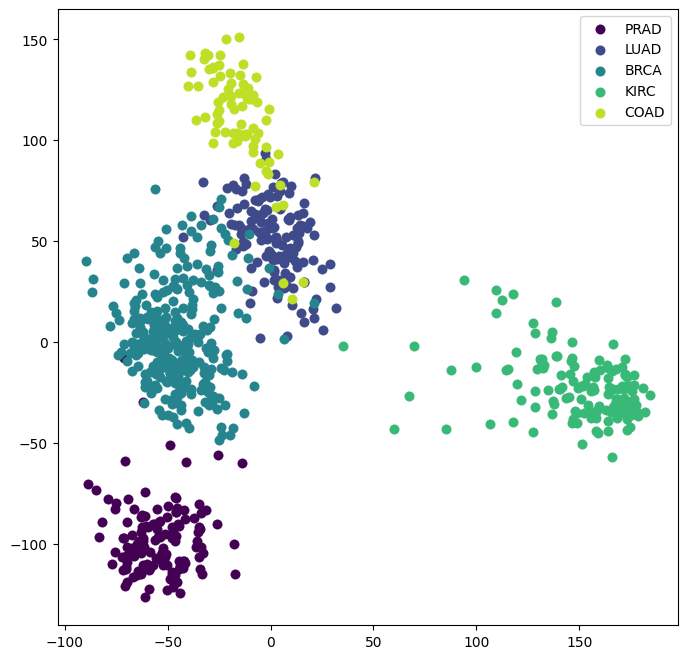

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

l_unq = df_plot['Class'].unique()
colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(l_unq))]

for i,c in enumerate(colorlist):

    _x = df_plot[df_plot.Class==l_unq[i]].x
    _y = df_plot[df_plot.Class==l_unq[i]].y
    l = l_unq[i]
    ax.scatter(_x, _y, label=l, s=50, linewidth=0.1, c=c)

ax.legend()
plt.show()

Looking at the characteristics of the data

In [ ]:
#Checking for null values
print("Checking for null values:",X_var.isnull().values.any(), "\n")

#Checking for blank spaces
print("Checking for blank spaces:", X_var.isna().values.any(), "\n")

#Checking for consisting Dtype
print("Checking for consisting Dtype")
X_var.info()

print("\n")

X_var.describe()

Checking for null values: False 

Checking for blank spaces: False 

Checking for consisting Dtype
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2       569 non-null    float64
 1   3       569 non-null    float64
 2   4       569 non-null    float64
 3   5       569 non-null    float64
 4   6       569 non-null    float64
 5   7       569 non-null    float64
 6   8       569 non-null    float64
 7   9       569 non-null    float64
 8   10      569 non-null    float64
 9   11      569 non-null    float64
 10  12      569 non-null    float64
 11  13      569 non-null    float64
 12  14      569 non-null    float64
 13  15      569 non-null    float64
 14  16      569 non-null    float64
 15  17      569 non-null    float64
 16  18      569 non-null    float64
 17  19      569 non-null    float64
 18  20      569 non-null    float64
 19  21      569 no

,2,3,4,5,6,7,8,9,10,11,...,22,23,24,25,26,27,28,29,30,31
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Matrix representation of the data

In [ ]:
X_var = df.iloc[:,:-1]
y_var = df.iloc[:,-1]
X_2 = X_var.to_numpy()
X_2 = X_2.astype("float64")
y_2 = y_var.to_numpy()

print("X shape:", X_2.shape)

X shape: (801, 20531)


### Adaptation to anomaly detection problem

We declare the samples that are not from a tumor of BRCA type (Breast cancer) as anomalies.

Therefore, our labels will be:

*   0 :  Normal sample (Breast cancer)
*   1 :  Anomalies (Other types of cancer)




In [ ]:
y_2 = [0 if i=='BRCA' else 1 for i in y_2]
y_2 = np.array(y_2)

## Dataset 3: Vertebral column dataset
- Source: https://archive.ics.uci.edu/dataset/212/vertebral+column
- Objective: Classify orthopedic patients based on biomechanical indicators (vertebral column)
- Dimension: 310 instances, 6 features


In [ ]:
# Load Dataset
url = 'https://raw.githubusercontent.com/alecruces/HW_optimization_FW/main/column_2C_2.csv'
df=pd.read_csv(url, header=None, sep = ";")
df

,0,1,2,3,4,5,6
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


In [ ]:
# Transform Data Frame to Dataset
X_var = df.drop([6], axis=1)
y_var = df[[6]]

X_3 = X_var.to_numpy()
y_3 = y_var.to_numpy()

y_3 = [1 if i=='AB' else 0 for i in y_3]
y_3 = np.array(y_3)

print("X shape:", X_3.shape)

X shape: (310, 6)


In [ ]:
y_var.value_counts()

#Checking for null values
print("Checking for null values:",X_var.isnull().values.any())

#Checking for consisting Dtype
print("Checking for consisting Dtype:",X_var.info())

#Checking for blank spaces
print(X_var.isna().values.any())

X_var.describe()

Checking for null values: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       310 non-null    float64
 1   1       310 non-null    float64
 2   2       310 non-null    float64
 3   3       310 non-null    float64
 4   4       310 non-null    float64
 5   5       310 non-null    float64
dtypes: float64(6)
memory usage: 14.7 KB
Checking for consisting Dtype: None
False


,0,1,2,3,4,5
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


## Data set 4: Maternity risk dataset
- Source: https://archive.ics.uci.edu/dataset/863/maternal+health+risk
- Objective: Detect Risk Intensity Level during pregnancy
- Dimension: 1014 instances, 6 features


In [ ]:
# Load data set
url = 'https://raw.githubusercontent.com/alecruces/HW_optimization_FW/main/Maternal%20Health%20Risk%20Data%20Set.csv'
df=pd.read_csv(url, header=None)
df

,0,1,2,3,4,5,6
0,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1,25,130,80,15,98,86,high risk
2,35,140,90,13,98,70,high risk
3,29,90,70,8,100,80,high risk
4,30,140,85,7,98,70,high risk
...,...,...,...,...,...,...,...
1010,22,120,60,15,98,80,high risk
1011,55,120,90,18,98,60,high risk
1012,35,85,60,19,98,86,high risk
1013,43,120,90,18,98,70,high risk


In [ ]:
df = df.drop(0).reset_index(drop=True)

In [ ]:
# Transform Data Frame to Dataset
X_var = df.iloc[:,:-1]
y_var = df.iloc[:,-1]
X_4 = X_var.to_numpy()
X_4 = X_4.astype("float64")
y_4 = y_var.to_numpy()

y_4 = [1 if i=='high risk' else 0 for i in y_4]
y_4 = np.array(y_4)

print("X shape:", X_4.shape)

X shape: (1014, 6)


# Numerical Experiments

### Split the dataset in test and training and scale

In [ ]:
# Split the dataset test and training
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, stratify = y,test_size=0.3, random_state=22)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, stratify = y_2,test_size=0.3, random_state=22)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, y_3, stratify = y_3,test_size=0.3, random_state=22)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X_4, y_4, stratify = y_4, test_size=0.3, random_state=22)

**Use of StandardScaler for the first dataset**

In [ ]:
scaler = StandardScaler()
scaler1 = scaler.fit(X_train1)
X_train1 = scaler1.transform(X_train1)
X_test1 = scaler1.transform(X_test1)

## Dataset 1


**Selecting best K**


In [ ]:
# Hyperparameter Tuning
k_best, recall_train = findBestK(X_train1,y_train1)

k = 2
Using  shortstep  as step size
min eigenvalue: -1.318719562538348e-13
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 571.1519540762586
Early Stopping
Iteration number:  553 of  100000
k = 3
Using  shortstep  as step size
min eigenvalue: -1.0159197222215387e-13
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 774.8831936236535
Early Stopping
Iteration number:  23759 of  100000
k = 4
Using  shortstep  as step size
min eigenvalue: -2.876363098867097e-13
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 995.6964582229832
Early Stopping
Iteration number:  2998 of  100000
k = 5
Using  shortstep  as step size
min eigenvalue: -2.917962613689136e-13
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 1242.457749534595
Early Stopping
Iteration number:  2070 of  100000
k = 6
Using  shortstep  as step size
min eigenvalue: -4.982

In [ ]:
k_best

4

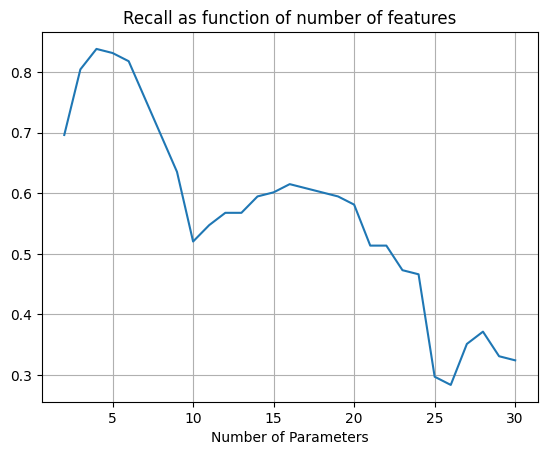

In [ ]:
parameters = np.arange(start=2, stop=31, step=1)
plt.plot(parameters, recall_train, label ='recall')
plt.xlabel('Number of Parameters')
plt.title('Recall as function of number of features')
plt.grid()
plt.show()

**Final Selection of the Model**

In [ ]:
selection = SelectKBest(k=k_best).fit(X_train1,y_train1)

X_train_kbest = selection.transform(X_train1)
X_test_kbest = selection.transform(X_test1)

X_normal_kbest, y_normal_kbest = keep_normal_class(X_train_kbest, y_train1, normal_value = 0)

**Algorithm 1: PFW**

In [ ]:
mu_pfw , center_MEB_pfw, r_MEB_pfw, gap_pfw, iter_count_pfw, time_pfw, radius_pfw, center_pfw, size_act_set_pfw = PFW(X_normal_kbest, step_type = step_type_selection)
y_predict_pfw = anomaly_detection(X_train_kbest, r_MEB_pfw, center_MEB_pfw)
recall_pfw, precision_pfw, accuracy_pfw, f1_score_pfw = metric_anomaly(y_train1, y_predict_pfw)

print("Recall Train: ", recall_pfw)
print("Precision Train: ", precision_pfw)
print("Radius: ", r_MEB_pfw)
print("Time: ", time_pfw[-1])


y_predict_test_pfw = anomaly_detection(X_test_kbest, r_MEB_pfw, center_MEB_pfw)
recall_pfw_test, precision_pfw_test, accuracy_pfw_test, f1_score_pfw_test = metric_anomaly(y_test1, y_predict_test_pfw)
print("Recall Test: ", recall_pfw_test)
print("Precision Test: ", precision_pfw_test)
print("Accuracy Test: ", accuracy_pfw_test)

Using  shortstep  as step size type
min eigenvalue: -2.876363098867097e-13
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 995.6964582229832
Early Stopping
Iteration number:  1484 of  100000
Recall Train:  0.8378378378378378
Precision Train:  0.992
Radius:  1.9478231192308377
Time:  279.179443359375
Recall Test:  0.84375
Precision Test:  0.9818181818181818
Accuracy Test:  0.935672514619883


**Algorithm 2: BPCG**

In [ ]:
mu_bpcg , center_MEB_bpcg, r_MEB_bpcg, gap_bpcg, iter_count_bpcg, drop_count_bpcg, time_bpcg, radius_bpcg, center_bpcg,size_act_set = BPCG(X_normal_kbest, step_type = step_type_selection)
y_predict_bpcg = anomaly_detection(X_train_kbest, r_MEB_bpcg, center_MEB_bpcg)
recall_bpcg, precision_bpcg, accuracy_bpcg, f1_score_bpcg = metric_anomaly(y_train1, y_predict_bpcg)

print("Recall Train: ", recall_bpcg)
print("Precision Train: ", precision_bpcg)
print("Radius: ", r_MEB_bpcg)
print("Time: ", time_bpcg[-1])


y_predict_test_bpcg = anomaly_detection(X_test_kbest, r_MEB_bpcg, center_MEB_bpcg)
recall_bpcg_test, precision_bpcg_test, accuracy_bpcg_test, f1_score_bpcg_test = metric_anomaly(y_test1, y_predict_test_bpcg)
print("Recall Test: ", recall_bpcg_test)
print("Precision Test: ", precision_bpcg_test)
print("Accuracy Test: ", accuracy_bpcg_test)

Using  shortstep  as step size
min eigenvalue: -2.876363098867097e-13
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 995.6964582229832
Early Stopping
Iteration number:  2998 of  100000
Recall Train:  0.8378378378378378
Precision Train:  0.992
Radius:  1.9478231192299775
Time:  604.57177734375
Recall Test:  0.84375
Precision Test:  0.9818181818181818
Accuracy Test:  0.935672514619883


**Algorithm 3: MEB aprox.**

In [ ]:
coreset, center,kappa,gamma, xi,delta, delta_plus, delta_minus,u = initial_values(X_normal_kbest)
delta_meb, r_meb, coreset_meb, center_meb, kappa_meb, gamma_meb, xi_meb, radius_history_meb, time_meb, iter_count_meb = algorithm_meb(X_normal_kbest, coreset, center, kappa, gamma, xi, delta, delta_plus, delta_minus,u)

y_predict_meb = anomaly_detection(X_train_kbest, r_meb, center_meb)
recall_meb, precision_meb, accuracy_meb, f1_score_meb = metric_anomaly(y_train1, y_predict_meb)

print("Recall Train: ", recall_meb)
print("Precision Train: ", precision_meb)
print("Radius: ", r_meb)
print("Time: ", time_meb[-1])

y_predict_test_meb = anomaly_detection(X_test_kbest, r_meb, center_meb)
recall_meb_test, precision_meb_test, accuracy_meb_test, f1_score_meb_test = metric_anomaly(y_test1, y_predict_test_meb)
print("Recall Test: ", recall_meb_test)
print("Precision Test: ", precision_meb_test)
print("Accuracy Test: ", accuracy_meb_test)

Initial values 

Gamma  3.5994966251460343
Delta  0.36455756467788447 

Early Stopping
Iteration number:  44 of  100000
Recall Train:  0.8378378378378378
Precision Train:  1.0
Radius:  1.9479783178403716
Time:  93.030029296875
Recall Test:  0.84375
Precision Test:  0.9818181818181818
Accuracy Test:  0.935672514619883


## Plots Results Dataset 1

In [ ]:
#Create iterations vector for graphs
iter_num_pfw = list(range(0,iter_count_pfw))
iter_num_bpcg = list(range(0,iter_count_bpcg))
iter_num_meb = list(range(0,iter_count_meb))

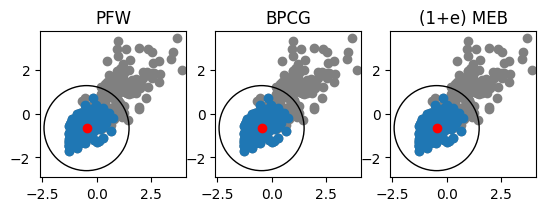

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

circle1 = Circle(center_MEB_pfw, r_MEB_pfw,edgecolor = 'black', facecolor="none")
circle2 = Circle(center_MEB_bpcg, r_MEB_bpcg,edgecolor = 'black', facecolor="none")
circle3 = Circle(center_meb, r_meb,edgecolor = 'black', facecolor="none")

ax1.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
ax1.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
ax1.scatter(center_MEB_pfw[0], center_MEB_pfw[1],color='red')

ax1.add_patch(circle1)
ax1.set_title('PFW')
ax1.set_aspect('equal')

ax2.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
ax2.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
ax2.scatter(center_MEB_bpcg[0], center_MEB_bpcg[1],color='red')

ax2.add_patch(circle2)
ax2.set_title('BPCG')
ax2.set_aspect('equal')

ax3.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
ax3.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
ax3.scatter(center_meb[0], center_meb[1],color='red')

ax3.add_patch(circle3)
ax3.set_title('(1+e) MEB')
ax3.set_aspect('equal')

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
plt.show()


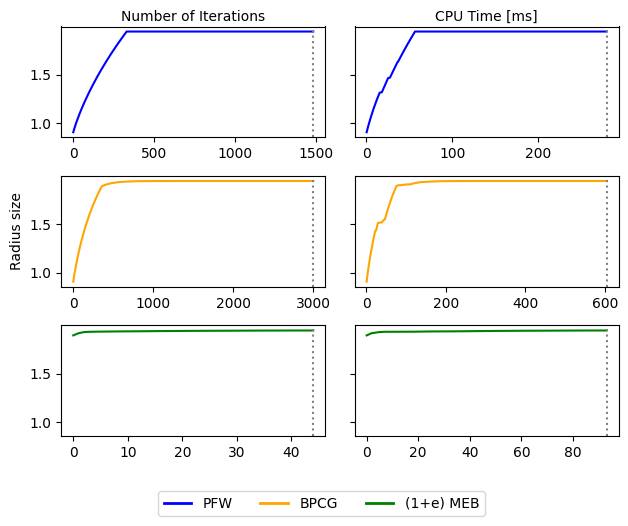

In [ ]:
# @title Comparing radius size through number of iterations and CPU time
plot_y_against_two_variables(radius_pfw, radius_bpcg, radius_history_meb,iter_num_pfw, iter_num_bpcg,
                             iter_num_meb,time_pfw, time_bpcg, time_meb,	["PFW",'BPCG','(1+e) MEB'],"Number of Iterations","CPU Time [ms]", "Radius size", sharey=True)


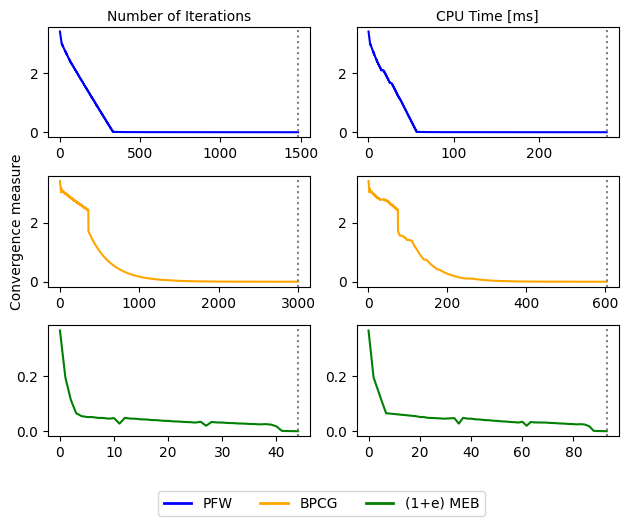

In [ ]:
# @title Comparing FW gap and Delta MEB through number of iterations and CPU time

plot_y_against_two_variables(gap_pfw, gap_bpcg, delta_meb,iter_num_pfw, iter_num_bpcg, iter_num_meb,time_pfw, time_bpcg, time_meb,	["PFW",'BPCG','(1+e) MEB'],"Number of Iterations","CPU Time [ms]", "Convergence measure", sharey=False)

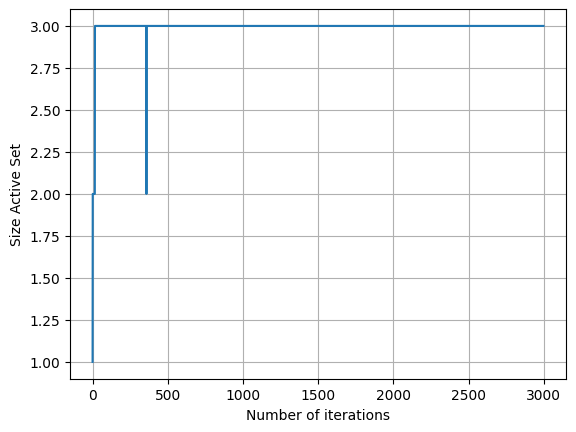

In [ ]:
plt.plot(size_act_set)
plt.xlabel('Number of iterations')
plt.ylabel('Size Active Set')
plt.title('')
plt.grid()
plt.show()

## Dataset 2

This dataset does not require Best K selection, because PCA was applied.

In [ ]:
X_train_kbest = X_train2
X_test_kbest = X_test2
X_normal_kbest, y_normal_kbest = keep_normal_class(X_train_kbest, y_train2, normal_value = 0)

In [ ]:
mu_pfw , center_MEB_pfw, r_MEB_pfw, gap_pfw, iter_count_pfw, time_pfw, radius_pfw, center_pfw, size_active_set = PFW(X_normal_kbest, step_type = step_type_selection)
y_predict_pfw = anomaly_detection(X_train_kbest, r_MEB_pfw, center_MEB_pfw)
recall_pfw, precision_pfw, accuracy_pfw, f1_score_pfw = metric_anomaly(y_train2, y_predict_pfw)

print("Recall Train: ", recall_pfw)
print("Precision Train: ", precision_pfw)
print("Accuracy : ", accuracy_pfw)
print("Time: ", time_pfw[-1])


y_predict_test_pfw = anomaly_detection(X_test_kbest, r_MEB_pfw, center_MEB_pfw)
recall_pfw_test, precision_pfw_test, accuracy_pfw_test, f1_score_pfw_test = metric_anomaly(y_test2, y_predict_test_pfw)
print("Recall Test: ", recall_pfw_test)
print("Precision Test: ", precision_pfw_test)
print("Accuracy Test: ", accuracy_pfw_test)

Using  shortstep  as step size type
min eigenvalue: 7376.663244420251
Checking if the matrix is positive definite
The matrix is positive definite
Lipschitz: 488176823.43138504
Maximum number of iterations reached
Recall Train:  0.8371428571428572
Precision Train:  0.9766666666666667
Accuracy :  0.8857142857142857
Time:  366275.94921875
Recall Test:  0.847682119205298
Precision Test:  0.9624060150375939
Accuracy Test:  0.8838174273858921


In [ ]:
mu_bpcg , center_MEB_bpcg, r_MEB_bpcg, gap_bpcg, iter_count_bpcg, drop_count_bpcg, time_bpcg, radius_bpcg, center_bpcg, size_active_set= BPCG(X_normal_kbest, step_type = step_type_selection)
y_predict_bpcg = anomaly_detection(X_train_kbest, r_MEB_bpcg, center_MEB_bpcg)
recall_bpcg, precision_bpcg, accuracy_bpcg, f1_score_bpcg = metric_anomaly(y_train2, y_predict_bpcg)

print("Recall Train: ", recall_bpcg)
print("Precision Train: ", precision_bpcg)
print("Time: ", time_bpcg[-1])

y_predict_test_bpcg = anomaly_detection(X_test_kbest, r_MEB_bpcg, center_MEB_bpcg)
recall_bpcg_test, precision_bpcg_test, accuracy_bpcg_test, f1_score_bpcg_test = metric_anomaly(y_test2, y_predict_test_bpcg)
print("Recall Test: ", recall_bpcg_test)
print("Precision Test: ", precision_bpcg_test)
print("Accuracy Test: ", accuracy_bpcg_test)

Using  shortstep  as step size
min eigenvalue: 7376.663244420251
Checking if the matrix is positive definite
The matrix is positive definite
Lipschitz: 488176823.43138504
Maximum number of iterations reached
Recall Train:  0.8514285714285714
Precision Train:  0.9802631578947368
Time:  370043.0939941406
Recall Test:  0.8609271523178808
Precision Test:  0.9629629629629629
Accuracy Test:  0.8921161825726142


In [ ]:
coreset, center,kappa,gamma, xi,delta, delta_plus, delta_minus,u = initial_values(X_normal_kbest)
delta_meb, r_meb, coreset_meb, center_meb, kappa_meb, gamma_meb, xi_meb, radius_history_meb, time_meb, iter_count_meb = algorithm_meb(X_normal_kbest, coreset, center, kappa, gamma, xi, delta, delta_plus, delta_minus,u)

y_predict_meb = anomaly_detection(X_train_kbest, r_meb, center_meb)
recall_meb, precision_meb, accuracy_meb, f1_score_meb = metric_anomaly(y_train2, y_predict_meb)

print("Recall Train: ", recall_meb)
print("Precision Train: ", precision_meb)
print("Time: ", time_meb[-1])

y_predict_test_meb = anomaly_detection(X_test_kbest, r_meb, center_meb)
recall_meb_test, precision_meb_test, accuracy_meb_test, f1_score_meb_test = metric_anomaly(y_test2, y_predict_test_meb)
print("Recall Test: ", recall_meb_test)
print("Precision Test: ", precision_meb_test)
print("Accuracy Test: ", accuracy_meb_test)

Initial values 

Gamma  34889.88882281026
Delta  1.233955628451627 

Early Stopping
Iteration number:  44 of  100000
Recall Train:  0.8371428571428572
Precision Train:  1.0
Time:  3505.138427734375
Recall Test:  0.847682119205298
Precision Test:  0.9624060150375939
Accuracy Test:  0.8838174273858921


## Plots Results Dataset 2

In [ ]:
#Create iterations vector for graphs
iter_num_pfw = list(range(0,iter_count_pfw))
iter_num_bpcg = list(range(0,iter_count_bpcg))
iter_num_meb = list(range(0,iter_count_meb))

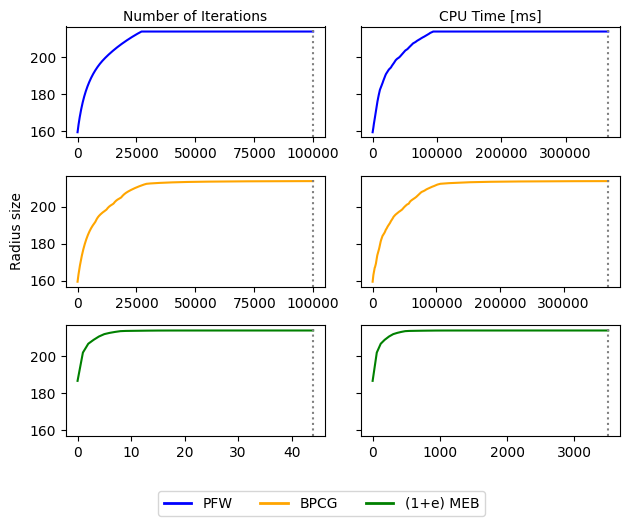

In [ ]:
# @title Comparing radius size through number of iterations and CPU time
plot_y_against_two_variables(radius_pfw, radius_bpcg, radius_history_meb,iter_num_pfw, iter_num_bpcg,
                             iter_num_meb,time_pfw, time_bpcg, time_meb,	["PFW",'BPCG','(1+e) MEB'],"Number of Iterations","CPU Time [ms]", "Radius size",sharey=True, geneDataset=True)


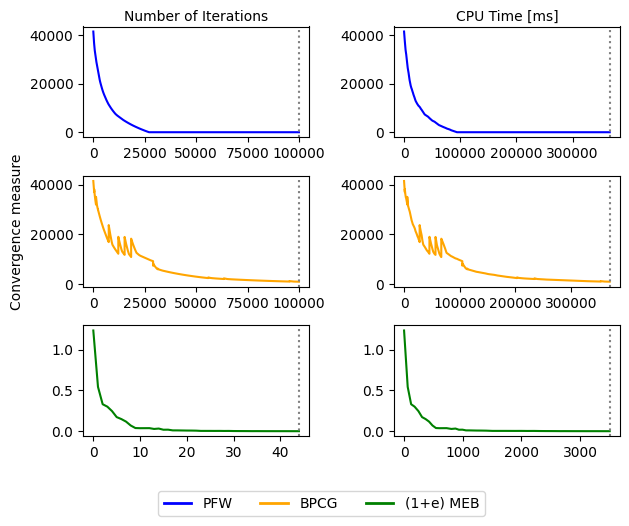

In [ ]:
# @title Comparing FW gap and Delta MEB through number of iterations and CPU time

plot_y_against_two_variables(gap_pfw, gap_bpcg, delta_meb,iter_num_pfw, iter_num_bpcg, iter_num_meb,time_pfw, time_bpcg, time_meb,	["PFW",'BPCG','(1+e) MEB'],"Number of Iterations","CPU Time [ms]", "Convergence measure")

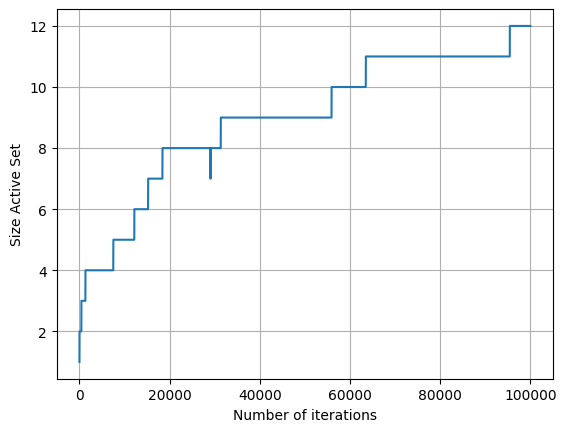

In [ ]:
plt.plot(size_active_set)
plt.xlabel('Number of iterations')
plt.ylabel('Size Active Set')
plt.title('')
plt.grid()
plt.show()

## Dataset 3

In [ ]:
# Hyperparameter Tuning
k_best, recall_train = findBestK(X_train3,y_train3)

k = 2
Using  shortstep  as step size
min eigenvalue: -3.513440241762786e-11
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 398418.5593095162
Early Stopping
Iteration number:  52194 of  100000
k = 3
Using  shortstep  as step size
min eigenvalue: -6.761633745309895e-11
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 424636.74175584276
Early Stopping
Iteration number:  1580 of  100000
k = 4
Using  shortstep  as step size
min eigenvalue: -5.845138484606833e-11
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 702462.7288849133
Early Stopping
Iteration number:  1744 of  100000
k = 5
Using  shortstep  as step size
min eigenvalue: -3.342888381206112e-10
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 2788671.310486865
Early Stopping
Iteration number:  6398 of  100000
k = 6
Using  shortstep  as step size
min eigenvalue: -7.12

In [ ]:
k_best

2

**Selection Final Model**

In [ ]:
selection = SelectKBest(k=k_best).fit(X_train3,y_train3)
X_train_kbest = selection.transform(X_train3)
X_test_kbest = selection.transform(X_test3)

X_normal_kbest, y_normal_kbest = keep_normal_class(X_train_kbest, y_train3, normal_value = 0)

In [ ]:
mu_pfw , center_MEB_pfw, r_MEB_pfw, gap_pfw, iter_count_pfw, time_pfw, radius_pfw, center_pfw, size_act_set_pfw = PFW(X_normal_kbest, step_type = step_type_selection)
y_predict_pfw = anomaly_detection(X_train_kbest, r_MEB_pfw, center_MEB_pfw)
recall_pfw, precision_pfw, accuracy_pfw, f1_score_pfw = metric_anomaly(y_train3, y_predict_pfw)

print("Recall Train: ", recall_pfw)
print("Precision Train: ", precision_pfw)
print("Radius: ", r_MEB_pfw)
print("Time: ", time_pfw[-1])


y_predict_test_pfw = anomaly_detection(X_test_kbest, r_MEB_pfw, center_MEB_pfw)
recall_pfw_test, precision_pfw_test, accuracy_pfw_test, f1_score_pfw_test = metric_anomaly(y_test3, y_predict_test_pfw)
print("Recall Test: ", recall_pfw_test)
print("Precision Test: ", precision_pfw_test)
print("Accuracy Test: ", accuracy_pfw_test)

Using  shortstep  as step size type
min eigenvalue: -3.513440241762786e-11
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 398418.5593095162
Early Stopping
Iteration number:  20411 of  100000
Recall Train:  0.5850340136054422
Precision Train:  0.9885057471264368
Radius:  28.10971921741479
Time:  1874.767333984375
Recall Test:  0.5079365079365079
Precision Test:  0.9411764705882353
Accuracy Test:  0.6451612903225806


In [ ]:
mu_bpcg , center_MEB_bpcg, r_MEB_bpcg, gap_bpcg, iter_count_bpcg, drop_count_bpcg, time_bpcg, radius_bpcg, center_bpcg, size_active_set = BPCG(X_normal_kbest, step_type = step_type_selection)
y_predict_bpcg = anomaly_detection(X_train_kbest, r_MEB_bpcg, center_MEB_bpcg)
recall_bpcg, precision_bpcg, accuracy_bpcg, f1_score_bpcg = metric_anomaly(y_train3, y_predict_bpcg)

print("Recall Train: ", recall_bpcg)
print("Precision Train: ", precision_bpcg)
print("Radius: ", r_MEB_bpcg)
print("Time: ", time_bpcg[-1])

y_predict_test_bpcg = anomaly_detection(X_test_kbest, r_MEB_bpcg, center_MEB_bpcg)
recall_bpcg_test, precision_bpcg_test, accuracy_bpcg_test, f1_score_bpcg_test = metric_anomaly(y_test3, y_predict_test_bpcg)
print("Recall Test: ", recall_bpcg_test)
print("Precision Test: ", precision_bpcg_test)
print("Accuracy Test: ", accuracy_bpcg_test)

Using  shortstep  as step size
min eigenvalue: -3.513440241762786e-11
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 398418.5593095162
Early Stopping
Iteration number:  52194 of  100000
Recall Train:  0.5850340136054422
Precision Train:  0.9772727272727273
Radius:  28.109719217411993
Time:  6015.902099609375
Recall Test:  0.5079365079365079
Precision Test:  0.9411764705882353
Accuracy Test:  0.6451612903225806


In [ ]:
coreset, center,kappa,gamma, xi,delta, delta_plus, delta_minus,u = initial_values(X_normal_kbest)
delta_meb, r_meb, coreset_meb, center_meb, kappa_meb, gamma_meb, xi_meb, radius_history_meb, time_meb, iter_count_meb = algorithm_meb(X_normal_kbest, coreset, center, kappa, gamma, xi, delta, delta_plus, delta_minus,u)

y_predict_meb = anomaly_detection(X_train_kbest, r_meb, center_meb)
recall_meb, precision_meb, accuracy_meb, f1_score_meb = metric_anomaly(y_train3, y_predict_meb)

print("Recall Train: ", recall_meb)
print("Precision Train: ", precision_meb)
print("Radius: ", r_meb)
print("Time: ", time_meb[-1])

y_predict_test_meb = anomaly_detection(X_test_kbest, r_meb, center_meb)
recall_meb_test, precision_meb_test, accuracy_meb_test, f1_score_meb_test = metric_anomaly(y_test3, y_predict_test_meb)
print("Recall Test: ", recall_meb_test)
print("Precision Test: ", precision_meb_test)
print("Accuracy Test: ", accuracy_meb_test)

Initial values 

Gamma  785.8662499999996
Delta  0.061919696894987775 

Early Stopping
Iteration number:  105 of  100000
Recall Train:  0.5850340136054422
Precision Train:  1.0
Radius:  28.112499578099
Time:  55.71630859375
Recall Test:  0.5079365079365079
Precision Test:  0.9411764705882353
Accuracy Test:  0.6451612903225806


## Plots Results Dataset 3

In [ ]:
#Create iterations vector for graphs
iter_num_pfw = list(range(0,iter_count_pfw))
iter_num_bpcg = list(range(0,iter_count_bpcg))
iter_num_meb = list(range(0,iter_count_meb))

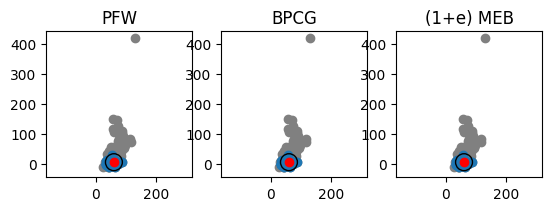

In [ ]:
if k_best == 2:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  circle1 = Circle(center_MEB_pfw, r_MEB_pfw, edgecolor = 'black', facecolor="none")
  circle2 = Circle(center_MEB_bpcg, r_MEB_bpcg,edgecolor = 'black', facecolor="none")
  circle3 = Circle(center_meb, r_meb,edgecolor = 'black', facecolor="none")

  ax1.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
  ax1.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
  ax1.scatter(center_MEB_pfw[0], center_MEB_pfw[1],color='red')

  ax1.add_patch(circle1)
  ax1.set_aspect('equal')
  ax1.set_title('PFW')


  ax2.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
  ax2.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
  ax2.scatter(center_MEB_bpcg[0], center_MEB_bpcg[1],color='red')

  ax2.add_patch(circle2)
  ax2.set_aspect('equal')
  ax2.set_title('BPCG')

  ax3.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
  ax3.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
  ax3.scatter(center_meb[0], center_meb[1],color='red')

  ax3.add_patch(circle3)
  ax3.set_aspect('equal')
  ax3.set_title('(1+e) MEB')

  ax1.set_box_aspect(1)
  ax2.set_box_aspect(1)
  ax3.set_box_aspect(1)

  plt.show()

elif k_best == 3:
  fig = plt.figure(figsize=(10,10))
  ax1 = fig.add_subplot(131, projection='3d')
  ax1.set_title('PFW')
  plt_sphere(center_MEB_pfw, r_MEB_pfw, X_test_kbest, y_test4,ax1)

  ax2 = fig.add_subplot(132, projection='3d')
  ax2.set_title('BPCG')
  plt_sphere(center_MEB_bpcg, r_MEB_bpcg, X_test_kbest, y_test4,ax2)

  ax3 = fig.add_subplot(133, projection='3d')
  ax3.set_title('(1+e) MEB')
  plt_sphere(center_meb, r_meb, X_test_kbest, y_test4,ax3)

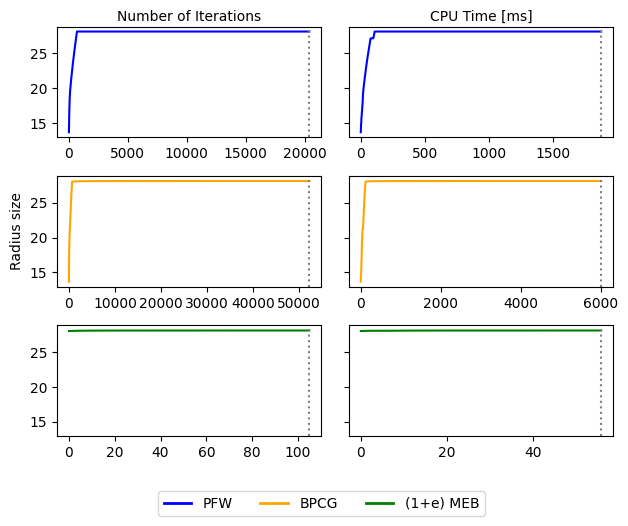

In [ ]:
# @title Comparing radius size through number of iterations and CPU time
plot_y_against_two_variables(radius_pfw, radius_bpcg, radius_history_meb,iter_num_pfw, iter_num_bpcg,
                             iter_num_meb,time_pfw, time_bpcg, time_meb,	["PFW",'BPCG','(1+e) MEB'],"Number of Iterations","CPU Time [ms]", "Radius size", sharey=True)


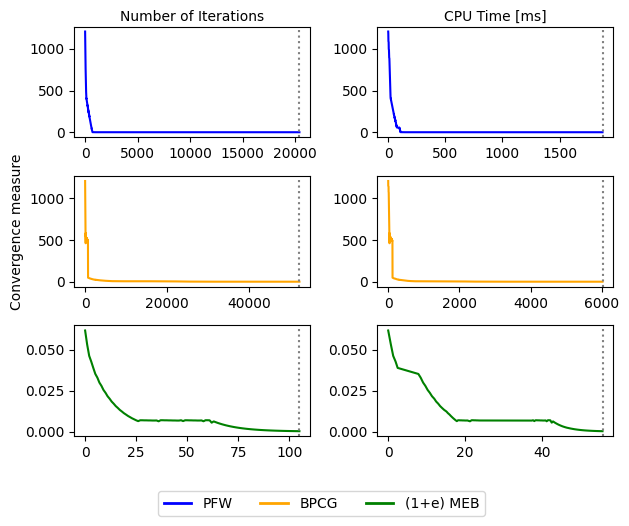

In [ ]:
# @title Comparing FW gap and Delta MEB through number of iterations and CPU time

plot_y_against_two_variables(gap_pfw, gap_bpcg, delta_meb,iter_num_pfw, iter_num_bpcg, iter_num_meb,time_pfw, time_bpcg, time_meb,	["PFW",'BPCG','(1+e) MEB'],"Number of Iterations","CPU Time [ms]", "Convergence measure", sharey=False)

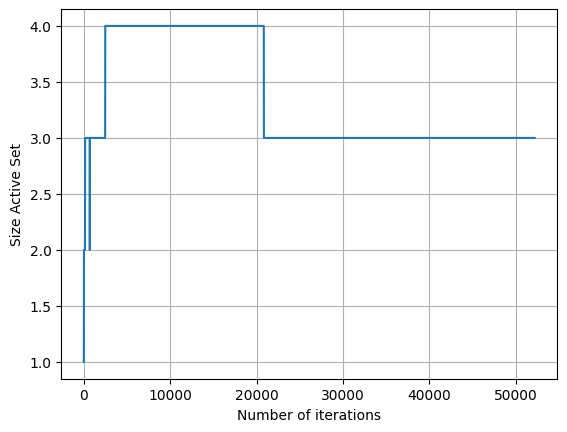

In [ ]:
plt.plot(size_active_set)
plt.xlabel('Number of iterations')
plt.ylabel('Size Active Set')
plt.title('')
plt.grid()
plt.show()

## Dataset 4

In [ ]:
# Hyperparameter Tuning
k_best, recall_train = findBestK(X_train4,y_train4)

k = 2
Using  shortstep  as step size
min eigenvalue: -1.7808100184371037e-09
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 5784376.620986981
Early Stopping
Iteration number:  22692 of  100000
k = 3
Using  shortstep  as step size
min eigenvalue: -3.770339951521209e-09
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 18357651.084824644
Maximum number of iterations reached
k = 4
Using  shortstep  as step size
min eigenvalue: -5.554527644498668e-09
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 19144338.89915021
Maximum number of iterations reached
k = 5
Using  shortstep  as step size
min eigenvalue: -8.193478722067114e-09
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 24632009.656745516
Maximum number of iterations reached
k = 6
Using  shortstep  as step size
min eigenvalue: -4.744071730902771e-09
Checking if the mat

In [ ]:
k_best

3

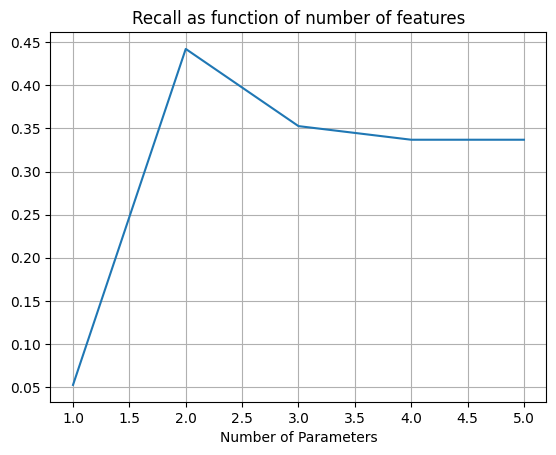

In [ ]:
parameters = np.arange(start=1, stop=6, step=1)
plt.plot(parameters, recall_train, label ='recall')
plt.xlabel('Number of Parameters')
plt.title('Recall as function of number of features')
plt.grid()
plt.show()

In [ ]:
selection = SelectKBest(k=k_best).fit(X_train4, y_train4)
X_train_kbest = selection.transform(X_train4)
X_test_kbest = selection.transform(X_test4)

X_normal_kbest, y_normal_kbest = keep_normal_class(X_train_kbest, y_train4, normal_value = 0)

In [ ]:
mu_pfw , center_MEB_pfw, r_MEB_pfw, gap_pfw, iter_count_pfw, time_pfw, radius_pfw, center_pfw, size_active_set= PFW(X_normal_kbest, step_type = step_type_selection)
y_predict_pfw = anomaly_detection(X_train_kbest, r_MEB_pfw, center_MEB_pfw)
recall_pfw, precision_pfw, accuracy_pfw, f1_score_pfw = metric_anomaly(y_train4, y_predict_pfw)

print("Recall Train: ", recall_pfw)
print("Precision Train: ", precision_pfw)
print("Time: ", time_pfw[-1])

y_predict_test_pfw = anomaly_detection(X_test_kbest, r_MEB_pfw, center_MEB_pfw)
recall_pfw_test, precision_pfw_test, accuracy_pfw_test, f1_score_pfw_test = metric_anomaly(y_test4, y_predict_test_pfw)
print("Recall Test: ", recall_pfw_test)
print("Precision Test: ", precision_pfw_test)
print("Accuracy Test: ", accuracy_pfw_test)

Using  shortstep  as step size type
min eigenvalue: -3.770339951521209e-09
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 18357651.084824644
Maximum number of iterations reached
Recall Train:  0.4263157894736842
Precision Train:  0.9642857142857143
Time:  40934.7998046875
Recall Test:  0.47560975609756095
Precision Test:  0.9512195121951219
Accuracy Test:  0.8524590163934426


In [ ]:
mu_bpcg , center_MEB_bpcg, r_MEB_bpcg, gap_bpcg, iter_count_bpcg, drop_count_bpcg, time_bpcg, radius_bpcg, center_bpcg, size_active_set= BPCG(X_normal_kbest, step_type = step_type_selection)
y_predict_bpcg = anomaly_detection(X_train_kbest, r_MEB_bpcg, center_MEB_bpcg)
recall_bpcg, precision_bpcg, accuracy_bpcg, f1_score_bpcg = metric_anomaly(y_train4, y_predict_bpcg)

print("Recall Train: ", recall_bpcg)
print("Precision Train: ", precision_bpcg)
print("Time: ", time_bpcg[-1])

y_predict_test_bpcg = anomaly_detection(X_test_kbest, r_MEB_bpcg, center_MEB_bpcg)
recall_bpcg_test, precision_bpcg_test, accuracy_bpcg_test, f1_score_bpcg_test = metric_anomaly(y_test4, y_predict_test_bpcg)
print("Recall Test: ", recall_bpcg_test)
print("Precision Test: ", precision_bpcg_test)
print("Accuracy Test: ", accuracy_bpcg_test)

Using  shortstep  as step size
min eigenvalue: -3.770339951521209e-09
Checking if the matrix is positive definite
The matrix is not positive definite
Lipschitz: 18357651.084824644
Maximum number of iterations reached
Recall Train:  0.4421052631578947
Precision Train:  0.9655172413793104
Time:  40493.79638671875
Recall Test:  0.5
Precision Test:  0.9534883720930233
Accuracy Test:  0.8590163934426229


In [ ]:
coreset, center,kappa,gamma, xi,delta, delta_plus, delta_minus,u = initial_values(X_normal_kbest)
delta_meb, r_meb, coreset_meb, center_meb, kappa_meb, gamma_meb, xi_meb, radius_history_meb, time_meb, iter_count_meb = algorithm_meb(X_normal_kbest, coreset, center, kappa, gamma, xi, delta, delta_plus, delta_minus,u)

y_predict_meb = anomaly_detection(X_train_kbest, r_meb, center_meb)
recall_meb, precision_meb, accuracy_meb, f1_score_meb = metric_anomaly(y_train4, y_predict_meb)

print("Recall Train: ", recall_meb)
print("Precision Train: ", precision_meb)
print("Time: ", time_meb[-1])

y_predict_test_meb = anomaly_detection(X_test_kbest, r_meb, center_meb)
recall_meb_test, precision_meb_test, accuracy_meb_test, f1_score_meb_test = metric_anomaly(y_test4, y_predict_test_meb)
print("Recall Test: ", recall_meb_test)
print("Precision Test: ", precision_meb_test)
print("Accuracy Test: ", accuracy_meb_test)

Initial values 

Gamma  1550.0
Delta  0.060316129032258026 

Early Stopping
Iteration number:  28 of  100000
Recall Train:  0.4263157894736842
Precision Train:  1.0
Time:  99.539306640625
Recall Test:  0.47560975609756095
Precision Test:  1.0
Accuracy Test:  0.8590163934426229


## Plots Results Dataset 4

In [ ]:
#Create iterations vector for graphs
iter_num_pfw = list(range(0,iter_count_pfw))
iter_num_bpcg = list(range(0,iter_count_bpcg))
iter_num_meb = list(range(0,iter_count_meb))

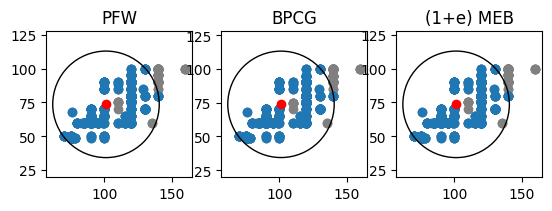

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

circle1 = Circle(center_MEB_pfw, r_MEB_pfw, edgecolor = 'black', facecolor="none")
circle2 = Circle(center_MEB_bpcg, r_MEB_bpcg,edgecolor = 'black', facecolor="none")
circle3 = Circle(center_meb, r_meb,edgecolor = 'black', facecolor="none")

ax1.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
ax1.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
ax1.scatter(center_MEB_pfw[0], center_MEB_pfw[1],color='red')
ax1.set_title('PFW')


ax1.add_patch(circle1)
ax1.set_aspect('equal')

ax2.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
ax2.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
ax2.scatter(center_MEB_bpcg[0], center_MEB_bpcg[1],color='red')
ax2.set_title('BPCG')

ax2.add_patch(circle2)
ax2.set_aspect('equal')

ax3.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
ax3.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
ax3.scatter(center_meb[0], center_meb[1],color='red')
ax3.set_title('(1+e) MEB')

ax3.add_patch(circle3)
ax3.set_aspect('equal')

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)

plt.show()

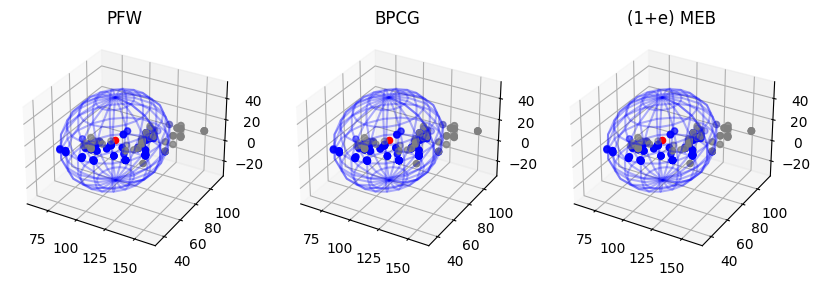

In [ ]:
if k_best == 2:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  circle1 = Circle(center_MEB_pfw, r_MEB_pfw, edgecolor = 'black', facecolor="none")
  circle2 = Circle(center_MEB_bpcg, r_MEB_bpcg,edgecolor = 'black', facecolor="none")
  circle3 = Circle(center_meb, r_meb,edgecolor = 'black', facecolor="none")

  ax1.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
  ax1.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
  ax1.scatter(center_MEB_pfw[0], center_MEB_pfw[1],color='red')

  ax1.add_patch(circle1)
  ax1.set_aspect('equal')
  ax1.set_title('PFW')


  ax2.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
  ax2.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
  ax2.scatter(center_MEB_bpcg[0], center_MEB_bpcg[1],color='red')

  ax2.add_patch(circle2)
  ax2.set_aspect('equal')
  ax2.set_title('BPCG')

  ax3.scatter(X_train_kbest.T[0, :], X_train_kbest.T[1, :],color='grey')
  ax3.scatter(X_normal_kbest.T[0, :], X_normal_kbest.T[1, :], marker="o")
  ax3.scatter(center_meb[0], center_meb[1],color='red')

  ax3.add_patch(circle3)
  ax3.set_aspect('equal')
  ax3.set_title('(1+e) MEB')

  ax1.set_box_aspect(1)
  ax2.set_box_aspect(1)
  ax3.set_box_aspect(1)

  plt.show()

elif k_best == 3:
  fig = plt.figure(figsize=(10,10))
  ax1 = fig.add_subplot(131, projection='3d')
  ax1.set_title('PFW')
  plt_sphere(center_MEB_pfw, r_MEB_pfw, X_test_kbest, y_test4,ax1)

  ax2 = fig.add_subplot(132, projection='3d')
  ax2.set_title('BPCG')
  plt_sphere(center_MEB_bpcg, r_MEB_bpcg, X_test_kbest, y_test4,ax2)

  ax3 = fig.add_subplot(133, projection='3d')
  ax3.set_title('(1+e) MEB')
  plt_sphere(center_meb, r_meb, X_test_kbest, y_test4,ax3)

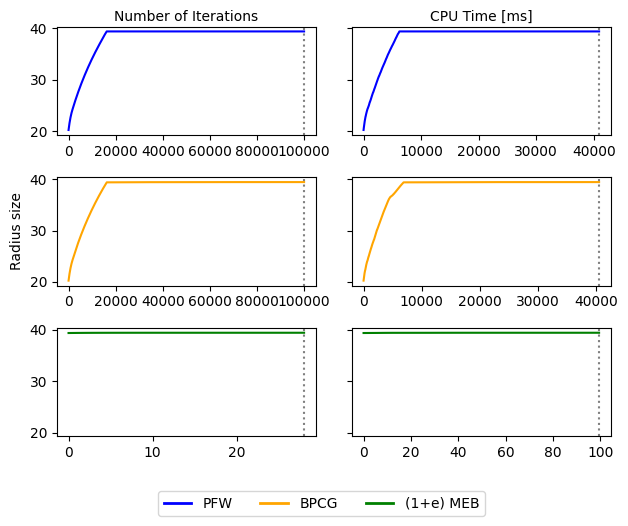

In [ ]:
# @title Comparing radius size through number of iterations and CPU time
plot_y_against_two_variables(radius_pfw, radius_bpcg, radius_history_meb,iter_num_pfw, iter_num_bpcg,
                             iter_num_meb,time_pfw, time_bpcg, time_meb,	["PFW",'BPCG','(1+e) MEB'],"Number of Iterations","CPU Time [ms]", "Radius size", sharey=True)


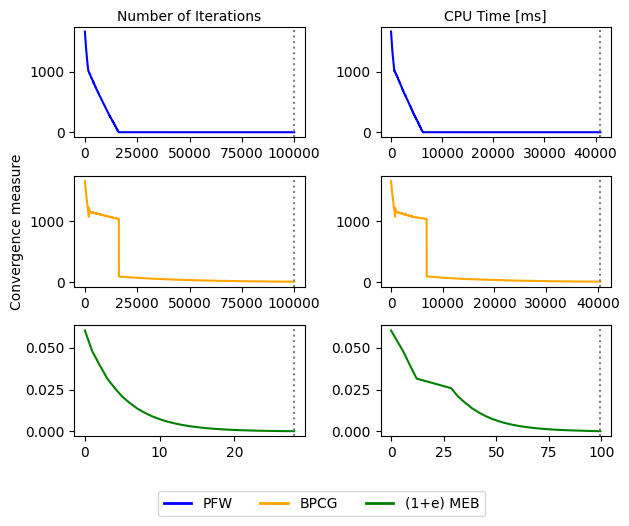

In [ ]:
# @title Comparing FW gap and Delta MEB through number of iterations and CPU time

plot_y_against_two_variables(gap_pfw, gap_bpcg, delta_meb,iter_num_pfw, iter_num_bpcg, iter_num_meb,time_pfw, time_bpcg, time_meb,	["PFW",'BPCG','(1+e) MEB'],"Number of Iterations","CPU Time [ms]", "Convergence measure", sharey=False)

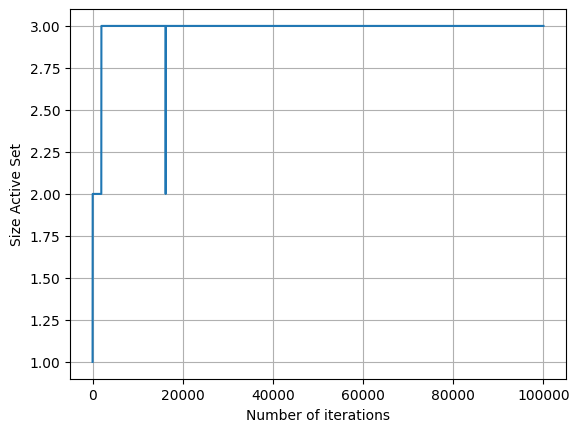

In [ ]:
plt.plot(size_active_set)
plt.xlabel('Number of iterations')
plt.ylabel('Size Active Set')
plt.title('')
plt.grid()
plt.show()